In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from lmfit.models import ExponentialModel, ConstantModel, BreitWignerModel
from scipy.optimize import curve_fit

## PL Data Processing

### PL Data Parameters

In [2]:
# data
PL_DIR = ("/Users/alexkolar/Library/CloudStorage/Box-Box/Zhonglab/Lab data/Ring Resonators"
          "/New_mounted_device/10mK/pl_08312024")
CAVITY_DIR = ("/Users/alexkolar/Library/CloudStorage/Box-Box/Zhonglab/Lab data/Ring Resonators"
              "/New_mounted_device/10mK/09032024/SDS00002.csv")
CAVITY_CALIB_DIR = ("/Users/alexkolar/Library/CloudStorage/Box-Box/Zhonglab/Lab data/Ring Resonators"
                    "/New_mounted_device/10mK/09032024/SDS00003.csv")

# for cavity fitting
FREQ_START = 194811.486  # unit: GHz
FREQ_END = 194819.973  # unit: GHz
AOM_FREQ = 0.6  # unit: GHz

# meta idx params
CAVITY_PEAK_RANGE = (3500, 4000)
CUTOFF_IDX = 5

# plotting params
mpl.rcParams.update({'font.sans-serif': 'Helvetica',
                     'font.size': 14})

### Fit PL Data

In [3]:
# get cavity calibration data
df = pd.read_csv(CAVITY_CALIB_DIR, header=10, skiprows=[11])
ramp = df['CH1'].astype(float).to_numpy()
transmission = df['CH2'].astype(float).to_numpy()

# find difference in scan edges
scan_max = np.argmax(ramp)
trans_max = np.argmax(transmission[CAVITY_PEAK_RANGE[0]:CAVITY_PEAK_RANGE[1]])
idx_diff = (trans_max + CAVITY_PEAK_RANGE[0]) - scan_max

print(f"IDX difference in ramp and scan: {idx_diff}")

# get cavity data
df = pd.read_csv(CAVITY_DIR, header=10, skiprows=[11])
ramp = df['CH1'].astype(float).to_numpy()
transmission = df['CH2'].astype(float).to_numpy()

id_min = np.argmin(ramp)
id_max = np.argmax(ramp)
ramp = ramp[id_min:id_max]
transmission = transmission[id_min+idx_diff:id_max+idx_diff]

# convert time to frequency
freq_cavity = np.linspace(0, (FREQ_END - FREQ_START), id_max-id_min)  # unit: GHz


# get PL data
pl_files = glob.glob(PL_DIR + "/*.npz")

model = ExponentialModel() + ConstantModel()
freqs = []
all_res = []
laser_pulses = []
areas = []
for file in pl_files:
    freq_str = os.path.basename(file).split('.')[0]
    freq_str = freq_str[5:]  # remove 'freq_'
    freq_str_decimal = freq_str.replace('_', '.')
    freq = float(freq_str_decimal)
    freqs.append(freq)

    data = np.load(file)
    bins = data['bins'][CUTOFF_IDX:]
    hist = data['hist'][CUTOFF_IDX:]
    laser_pulses.append(data['hist'][0])
    areas.append(np.sum(hist))

    res = model.fit(hist, x=bins,
                    decay=0.01)
    all_res.append(res)

freqs = np.array(freqs)
freq_min = min(freqs)
freqs = freqs - freq_min

# get data from fits
tau = np.fromiter(map(lambda x: x.params['decay'].value, all_res), float)
tau_err = np.fromiter(map(lambda x: x.params['decay'].stderr, all_res), float)

# sort according to frequency
sorted_args = np.argsort(freqs)
freqs = freqs[sorted_args]
tau = tau[sorted_args]
tau_err = tau_err[sorted_args]

IDX difference in ramp and scan: 202


## Fit T1 Data

### T1 Data Parameters

The function to fit is:
$$
\frac{1}{2\pi T_\mathrm{eff}} = \frac{1}{2\pi T_1} + \frac{\kappa g_\mathrm{eff}^2}{(\kappa / 2)^2 + \delta^2} = \frac{1}{2\pi T_1} + \frac{\kappa g_\mathrm{eff}^2}{(\kappa / 2)^2 + (\nu - \nu_0)^2}
$$

In [4]:
FIT_RANGE = (3, 7)  # units: GHz

# guesses for parameters
T_1_guess = 10e-3  # units: s
kappa_guess = 0.5  # units: GHz
g_eff_guess = 0.1  # units: MHz
nu_0_guess = 5.5  # units: GHz

### Fitting T1 Data

In [15]:
def fit_func(nu, T_1, kappa, g_eff, nu_0):
    T_eff_inverse = (1 / (2 * np.pi * T_1)) + (kappa * (g_eff ** 2)) / (((kappa / 2) ** 2) + ((nu - nu_0) ** 2))
    ret_val = 1 / (2 * np.pi * T_eff_inverse)
    return ret_val


# function with constrained kappa
def fit_func_mod(nu, T_1, g_eff, nu_0):
    kappa = 700e6
    T_eff_inverse = (1 / (2 * np.pi * T_1)) + (kappa * (g_eff ** 2)) / (((kappa / 2) ** 2) + ((nu - nu_0) ** 2))
    ret_val = 1 / (2 * np.pi * T_eff_inverse)
    return ret_val

In [16]:
idx_to_fit = np.where(np.logical_and(freqs > FIT_RANGE[0], freqs < FIT_RANGE[1]))[0]

# convert guesses to s and Hz
p0 = [T_1_guess,
      kappa_guess * 1e9,
      g_eff_guess * 1e6,
      nu_0_guess * 1e9]
freqs_to_fit = freqs[idx_to_fit]
freqs_to_fit = freqs_to_fit * 1e9

popt, pcov = curve_fit(fit_func, xdata=freqs_to_fit, ydata=tau[idx_to_fit], p0=p0)

In [22]:
print("Fit Results:")
print(f"\tT_1: {popt[0]*1e3:.3f} +/- {np.sqrt(pcov[0][0])*1e3:.3f} ms")
print(f"\tkappa: {popt[1]*1e-6:.3f} +/- {np.sqrt(pcov[1][1])*1e-6:.3f} MHz")
print(f"\tg_eff: {np.abs(popt[2]*1e-3):.3f} +/- {np.sqrt(pcov[2][2])*1e-3:.3f} kHz")
print(f"\tnu_0: {popt[3]*1e-9:.3f} +/- {np.sqrt(pcov[3][3])*1e-9:.3f} GHz")

Fit Results:
	T_1: 9.860 +/- 0.185 ms
	kappa: 969.461 +/- 171.352 MHz
	g_eff: 42.753 +/- 3.270 kHz
	nu_0: 5.795 +/- 0.046 GHz


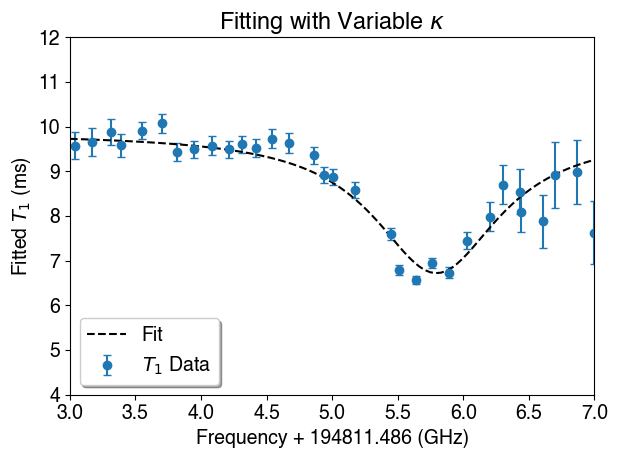

In [23]:
x_points = np.linspace(FIT_RANGE[0], FIT_RANGE[1], 100)

plt.errorbar(freqs, tau*1e3, yerr=tau_err*1e3,
             label=r'$T_1$ Data',
             marker='o', ls='', capsize=3)
plt.plot(x_points, fit_func(x_points*1e9, *popt)*1e3,
         label='Fit',
         ls='--', color='k')

plt.xlim(FIT_RANGE)
plt.ylim(4, 12)

plt.title(r'Fitting with Variable $\kappa$')
plt.xlabel(f'Frequency + {FREQ_START} (GHz)')
plt.ylabel(r'Fitted $T_1$ (ms)')
plt.legend(shadow=True, loc='lower left')

plt.tight_layout()
plt.show()

### Fitting T1 Data with Fixed kappa

In [9]:
idx_to_fit = np.where(np.logical_and(freqs > FIT_RANGE[0], freqs < FIT_RANGE[1]))[0]

# convert guesses to s and Hz
p0_mod = [T_1_guess,
      g_eff_guess * 1e6,
      nu_0_guess * 1e9]
freqs_to_fit = freqs[idx_to_fit]
freqs_to_fit = freqs_to_fit * 1e9

popt, pcov = curve_fit(fit_func_mod, xdata=freqs_to_fit, ydata=tau[idx_to_fit], p0=p0_mod)

In [10]:
print("Fit Results:")
print(f"\tT_1: {popt[0]*1e3:.3f} +/- {np.sqrt(pcov[0][0])*1e3:.3f} ms")
print(f"\tg_eff: {popt[1]*1e-3:.3f} +/- {np.sqrt(pcov[1][1])*1e-3:.3f} kHz")
print(f"\tnu_0: {popt[2]*1e-9:.3f} +/- {np.sqrt(pcov[2][2])*1e-9:.3f} GHz")

Fit Results:
	T_1: 9.645 +/- 0.121 ms
	g_eff: 38.434 +/- 1.999 kHz
	nu_0: 5.776 +/- 0.038 GHz


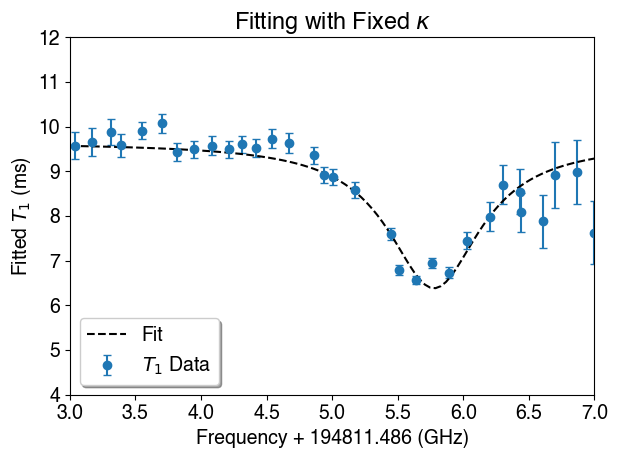

In [11]:
x_points = np.linspace(FIT_RANGE[0], FIT_RANGE[1], 100)

plt.errorbar(freqs, tau*1e3, yerr=tau_err*1e3,
             label=r'$T_1$ Data',
             marker='o', ls='', capsize=3)
plt.plot(x_points, fit_func_mod(x_points*1e9, *popt)*1e3,
         label='Fit',
         ls='--', color='k')

plt.xlim(FIT_RANGE)
plt.ylim(4, 12)

plt.title(r'Fitting with Fixed $\kappa$')
plt.xlabel(f'Frequency + {FREQ_START} (GHz)')
plt.ylabel(r'Fitted $T_1$ (ms)')
plt.legend(shadow=True, loc='lower left')

plt.tight_layout()
plt.show()

## Fit Cavity Reflection

In [12]:
x_data = freq_cavity + (FREQ_START - freq_min - AOM_FREQ)

guesses = {'amplitude': -0.005,
           'center': 5.9,
           'sigma': 0.9,
           'q': 10,
           'c': 0.7}

model = BreitWignerModel() + ConstantModel()
res = model.fit(transmission, x=x_data,
                **guesses)

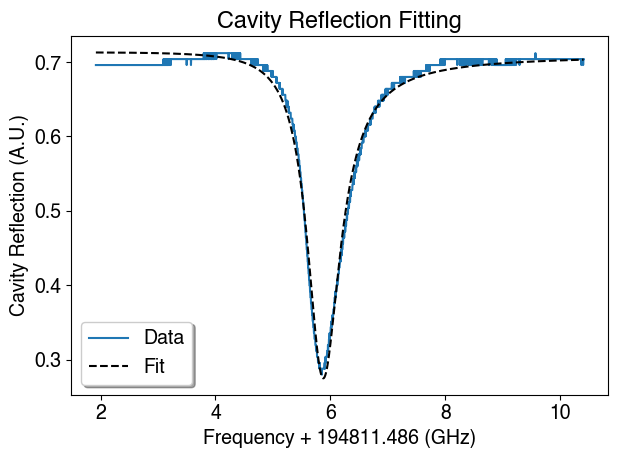

In [24]:
plt.plot(x_data, transmission,
         label='Data')
plt.plot(x_data, res.best_fit,
         ls='--', c='k', label='Fit')

plt.xlabel(f'Frequency + {FREQ_START} (GHz)')
plt.ylabel('Cavity Reflection (A.U.)')
plt.title('Cavity Reflection Fitting')
plt.legend(shadow=True)

plt.tight_layout()
plt.show()

In [14]:
print(res.fit_report())

[[Model]]
    (Model(breit_wigner) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 5002
    # variables        = 5
    chi-square         = 0.55444972
    reduced chi-square = 1.1096e-04
    Akaike info crit   = -45545.0761
    Bayesian info crit = -45512.4881
    R-squared          = 0.98844009
[[Variables]]
    amplitude: -0.00236165 +/- 6.8442e-05 (2.90%) (init = -0.005)
    center:     5.85099238 +/- 9.9106e-04 (0.02%) (init = 5.9)
    sigma:      0.69551057 +/- 0.00214192 (0.31%) (init = 0.9)
    q:          13.5797140 +/- 0.19744371 (1.45%) (init = 10)
    c:          0.71296021 +/- 2.0263e-04 (0.03%) (init = 0.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, q)      = +0.9979
    C(center, q)         = +0.7465
    C(amplitude, center) = +0.7449
    C(sigma, c)          = +0.4523
    C(amplitude, c)      = -0.2791
    C(q, c)              = -0.2753
    C(center, c)         = -0.2